# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [1]:
import numpy as np 

H = np.load('Hamiltonian_Example.npy')

In [2]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-3.34084762e+00+0.00000000e+00j, -3.29295138e+00+0.00000000e+00j,
       -2.86387634e+00+0.00000000e+00j, -2.78526086e+00+0.00000000e+00j,
       -1.56155281e+00+0.00000000e+00j, -1.56155281e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -5.61552813e-01+0.00000000e+00j, -5.61552813e-01+0.00000000e+00j,
        7.31507328e-16+0.00000000e+00j,  5.07690516e-01+0.00000000e+00j,
        5.23028722e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00-1.27192026e-16j,
        1.00000000e+00+1.27192026e-16j,  1.47697128e+00+0.00000000e+00j,
        1.49230948e+00+0.00000000e+00j,  2.00000000e+00+0.00000000e+00j,
        2.56155281e+00+0.00000000e+00j,  2.56155281e+00+0.00000000e+00j,
        3.00000000e+00+0.00000000e+00j,  3.00000000

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [3]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [4]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [5]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,1.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,1.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,2.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,1.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [6]:
print(blocks['0,0'])

SummedOp([
  3.25 * III,
  -0.5 * IIX,
  0.25 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -2.25 * IZI,
  -0.5 * IZX,
  0.25 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -2.0 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [7]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-7-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-7-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [8]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,2,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,1,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,1,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,1,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,1,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,1,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,1,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,2,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [9]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

-3.3408476172483366
(-3.340847617248337+0j)


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [10]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [13]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    cir_i.cx(2,1)
    cir_i.ry(phi_i[1],1)
    cir_i.cx(2,1)
    cir_i.cx(1,0)
    
    return cir_i


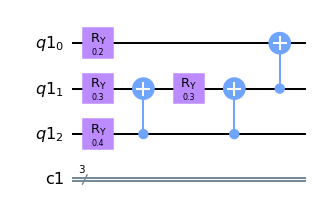

In [14]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [15]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


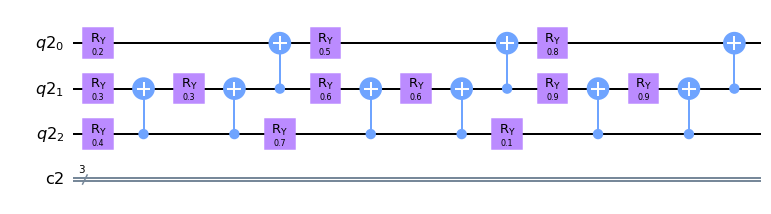

In [16]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

In order to deal with off diagonal blocks, we will also need to form $$ U^{ab} = I\otimes U^a + X \otimes U^b$$

In order to create this gate we need a controled-Ry gate.  The controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [17]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    cir_i.cx(2,1)
    cir_i.ry(phi_a[1],1)
    cir_i.cx(Q,1)
    cir_i.ry(-(phi_b[1]-phi_a[1])/2,1)
    cir_i.cx(Q,1)
    cir_i.ry((phi_b[1]-phi_a[1])/2,1)
    cir_i.cx(2,1)
    cir_i.cx(1,0)
    
    return cir_i

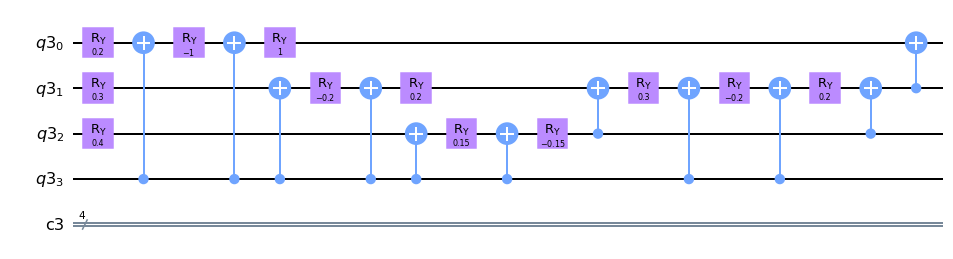

In [18]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

Let's check to make sure we are generating the right thing

In [19]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[ 6.58751847e-01+0.j  6.60956506e-02+0.j  2.04457807e-02+0.j
  2.03775826e-01+0.j  1.39778614e-01+0.j  1.40246414e-02+0.j
 -1.64291053e-19+0.j  1.51316259e-20+0.j]
B:
[ 2.45009585e-01+0.j  4.81384948e-01+0.j  4.05464949e-01+0.j
  2.06368727e-01+0.j  1.60303634e-02+0.j  3.14958113e-02+0.j
 -1.53339781e-18+0.j  7.26660298e-19+0.j]
AB:
[ 6.58751847e-01+0.j  6.60956506e-02+0.j  2.04457807e-02+0.j
  2.03775826e-01+0.j  1.39778614e-01+0.j  1.40246414e-02+0.j
 -1.72720547e-19+0.j  3.27628044e-18+0.j  2.45009585e-01+0.j
  4.81384948e-01+0.j  4.05464949e-01+0.j  2.06368727e-01+0.j
  1.60303634e-02+0.j  3.14958113e-02+0.j  6.31991825e-18+0.j
 -4.64144274e-18+0.j]


In [20]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

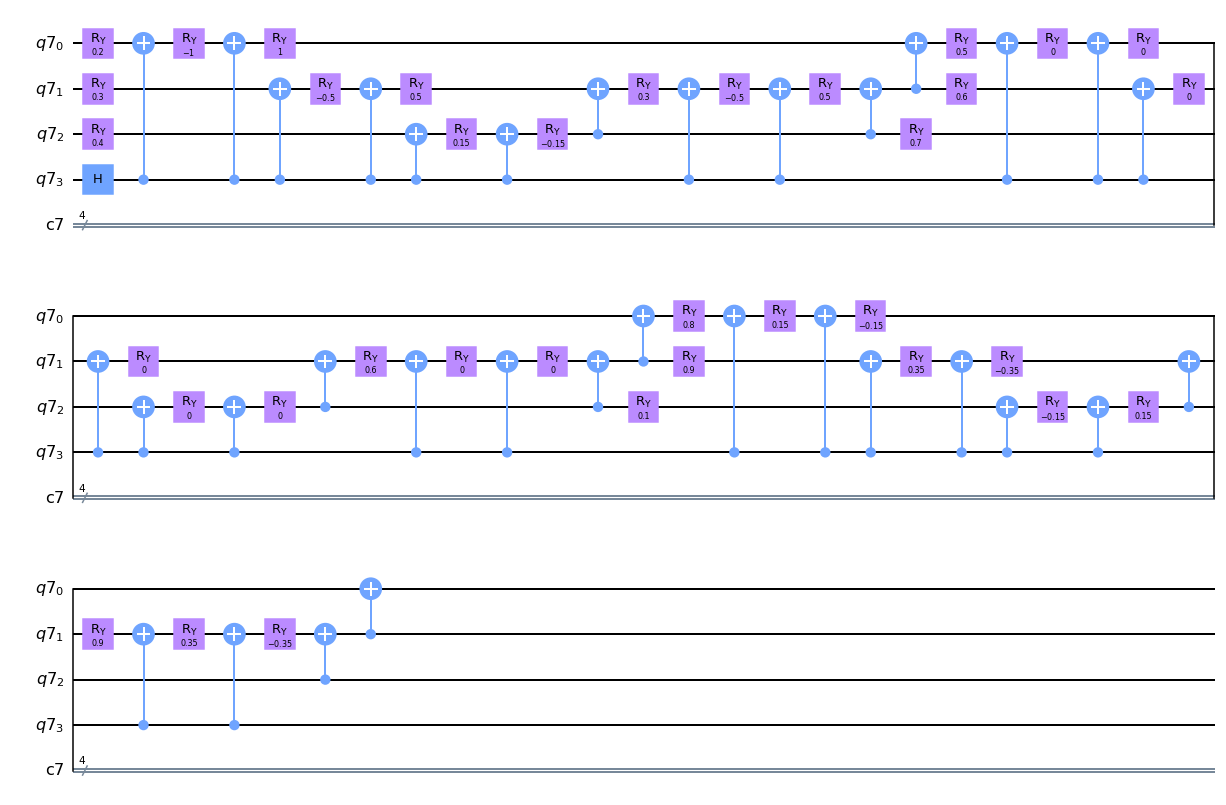

In [21]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [22]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][17].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(-0.17760781330743708+0j)
-0.1776078133074372
-0.193359375


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [23]:
import random

#number of blocks
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for t in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from on diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = block.to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (1.9073477631749876+0j)
simple: (1.9073477631749873+0j)
matrix: 1.9073477631749878
simulator: 1.89697265625


In [24]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli('X' + p_label,psi,method = method)
        E += w*E_p
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = block.to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (-0.7622820288664277+0j)
simple: (-0.762282028866428+0j)
matrix: -0.7622820288664283
simulator: -0.78564453125


Now we need to add all of the blocks together

In [25]:
# The total energy 
def find_E(phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += E_on_block(phi[int(key[0])],blocks[key],method = 'simple')
        else:
            E += 2*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = 'simple')
    return E/bL
            
find_E(phi,blocks)

(-0.6026373569307504+0j)

In [26]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))/bL


(-0.60263735693075+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [58]:
#number of blocks
T = 3

phi = []
for b in range(bL):
    phi_b = []
    for t in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(phi,blocks)

(-0.33333333333333304+0j)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [59]:
import copy

In [67]:
#alpha = 0.602
alpha = 0.201
A = 10
a = 0.1
gamma = 0.101
c = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
            
        #Find E    
        E_A = find_E(phi_k + c_k*Delta_k, blocks, method = method)
        E_B = find_E(phi_k - c_k*Delta_k, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(find_E(phi_k, blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [80]:
out = SPSA(1200,method = 'simple',hold = True)

k= 0 c_k= 0.4 a_k= 0.061756129649196564 g= 0.35449928425524774 E_A= (0.6018996931421775+0j) E_B= (0.3183002657379793+0j) E_f= -0.3663343787833904
k= 1 c_k= 0.372954594574733 a_k= 0.06068544899919707 g= -0.12418323906621345 E_A= (-0.14025647148053103+0j) E_B= (-0.047627052322697455+0j) E_f= -0.3716041907645365
k= 2 c_k= 0.3579898757427053 a_k= 0.059716918077675006 g= -0.06275488404064078 E_A= (0.8256333365895729+0j) E_B= (0.8705645628694867+0j) E_f= -0.3732161228397085
k= 3 c_k= 0.34773782403600867 a_k= 0.05883398491788389 g= -0.5904707106597533 E_A= (-0.13621577363155102+0j) E_B= (0.27444222653208555+0j) E_f= -0.39756118472378355
k= 4 c_k= 0.33998833831625347 a_k= 0.05802373178499532 g= 1.2542623923068756 E_A= (0.4398042760126759+0j) E_B= (-0.41306489713329114+0j) E_f= -0.4939940236409912
k= 5 c_k= 0.3337849224236992 a_k= 0.05727589489898785 g= 0.5498797782648807 E_A= (0.6406204442334837+0j) E_B= (0.2735372859724755+0j) E_f= -0.4833661596609643
k= 6 c_k= 0.32862839767254015 a_k= 0.0565

k= 51 c_k= 0.268375986369122 a_k= 0.043624380270768356 g= 0.10937239814698435 E_A= (-1.3259032266686839+0j) E_B= (-1.3846090771371904+0j) E_f= -1.8565883223165962
k= 52 c_k= 0.267860162826851 a_k= 0.04348430663466619 g= -0.2774725366101994 E_A= (-1.2730571498823222+0j) E_B= (-1.1244094722095475+0j) E_f= -1.8515076664063597
k= 53 c_k= 0.26735494522142605 a_k= 0.04334687817573433 g= 1.3482377657181406 E_A= (-0.583139602389608+0j) E_B= (-1.3040556703876707+0j) E_f= -1.8786131172248839
k= 54 c_k= 0.2668599250350944 a_k= 0.04321200476560672 g= -0.23809565600017613 E_A= (-1.4126535766731552+0j) E_B= (-1.285577198850378+0j) E_f= -1.8819192872040906
k= 55 c_k= 0.26637471655715955 a_k= 0.04307960067405643 g= 1.460951969558623 E_A= (-0.1840733185340515+0j) E_B= (-0.9623946521236559+0j) E_f= -1.9115074009993025
k= 56 c_k= 0.2658989552298248 a_k= 0.04294958429154924 g= 0.7556554635520637 E_A= (-0.91031515010154+0j) E_B= (-1.3121711466459454+0j) E_f= -1.9200143064782709
k= 57 c_k= 0.265432296140675

k= 102 c_k= 0.25047444999544133 a_k= 0.03866617683999727 g= -0.2715462700422383 E_A= (-1.8867937076291474+0j) E_B= (-1.750762902354861+0j) E_f= -2.5812380733068903
k= 103 c_k= 0.25023014297472496 a_k= 0.038597762090530556 g= 0.12408007054201821 E_A= (-1.3525253947256788+0j) E_B= (-1.4146225423097651+0j) E_f= -2.582198210668489
k= 104 c_k= 0.24998840873867942 a_k= 0.03853006432777713 g= -0.7395465704770112 E_A= (-1.277441939905684+0j) E_B= (-0.9076857992222926+0j) E_f= -2.5771731043215844
k= 105 c_k= 0.24974919607452548 a_k= 0.03846306990029804 g= -1.292877830164519 E_A= (-1.7439669107750109+0j) E_B= (-1.09817651336268+0j) E_f= -2.5962569943477645
k= 106 c_k= 0.2495124552599996 a_k= 0.03839676553143118 g= 0.9179709654348549 E_A= (-1.2864876394811982+0j) E_B= (-1.7445780183672839+0j) E_f= -2.6072654286787227
k= 107 c_k= 0.24927813800651724 a_k= 0.03833113830590295 g= -0.787313943772397 E_A= (-1.8530151933729428+0j) E_B= (-1.460494885512641+0j) E_f= -2.6171915311179124
k= 108 c_k= 0.24904

k= 152 c_k= 0.24066124374307757 a_k= 0.03592115492530083 g= -0.029998174292370606 E_A= (-1.9849637680444738+0j) E_B= (-1.9705249721740268+0j) E_f= -2.742002756419371
k= 153 c_k= 0.24050294487280224 a_k= 0.03587702196895213 g= -0.2075570892258722 E_A= (-2.095050672383593+0j) E_B= (-1.9952144900074944+0j) E_f= -2.743146760907349
k= 154 c_k= 0.24034577371294386 a_k= 0.035833211028443786 g= 0.4735308336284711 E_A= (-1.6713837505250932+0j) E_B= (-1.8990060196958336+0j) E_f= -2.741962811857892
k= 155 c_k= 0.2401897150315199 a_k= 0.035789717823822474 g= -0.20057468188510277 E_A= (-2.038793263484847+0j) E_B= (-1.9424413121158057+0j) E_f= -2.7438742576108117
k= 156 c_k= 0.24003475389827156 a_k= 0.03574653815736915 g= -0.3645672916364619 E_A= (-1.643295150166951+0j) E_B= (-1.468277509912316+0j) E_f= -2.744512190188532
k= 157 c_k= 0.23988087567680955 a_k= 0.03570366791153773 g= 0.5996588917601094 E_A= (-1.5217370143858693+0j) E_B= (-1.8094304145114697+0j) E_f= -2.7515017708116476
k= 158 c_k= 0.23

k= 202 c_k= 0.2338852810506788 a_k= 0.034040481906851175 g= -0.3428626261849891 E_A= (-1.8299661922712573+0j) E_B= (-1.6695851488971574+0j) E_f= -2.816718548352343
k= 203 c_k= 0.23376922896323718 a_k= 0.03400844944971238 g= 0.6988064758850675 E_A= (-1.6696032144700041+0j) E_B= (-1.9963221165943426+0j) E_f= -2.830969267010623
k= 204 c_k= 0.23365380153244633 a_k= 0.033976596261045884 g= -0.5753760749936911 E_A= (-1.9499632830689235+0j) E_B= (-1.6810856686027358+0j) E_f= -2.831563159638355
k= 205 c_k= 0.23353899237344763 a_k= 0.03394492051074589 g= -0.15263558610281794 E_A= (-2.262091817056853+0j) E_B= (-2.1907990950992877+0j) E_f= -2.832318513855251
k= 206 c_k= 0.23342479519724088 a_k= 0.033913420395752715 g= 0.8380498271430878 E_A= (-1.521660954711475+0j) E_B= (-1.9129041732433918+0j) E_f= -2.821805699189446
k= 207 c_k= 0.23331120380879006 a_k= 0.033882094139530645 g= 0.9500385600235515 E_A= (-1.4967519405692855+0j) E_B= (-1.940061220777014+0j) E_f= -2.825495886278944
k= 208 c_k= 0.2331

k= 253 c_k= 0.22865030548461726 a_k= 0.03260300350733771 g= -0.03071000829836242 E_A= (-2.037000653868676+0j) E_B= (-2.0229569483109646+0j) E_f= -2.8777589957541574
k= 254 c_k= 0.22855958199258958 a_k= 0.032578237071927925 g= -0.6214250036789797 E_A= (-2.3942295537649825+0j) E_B= (-2.1101642756037604+0j) E_f= -2.8796520556904346
k= 255 c_k= 0.22846924936970905 a_k= 0.03255358262633314 g= 0.04059655219557523 E_A= (-1.914947970437289+0j) E_B= (-1.9334980980515315+0j) E_f= -2.879629465408538
k= 256 c_k= 0.22837930441497245 a_k= 0.03252903924598524 g= 0.06638322186230912 E_A= (-2.2801321395072414+0j) E_B= (-2.3104532475747193+0j) E_f= -2.8797327285821646
k= 257 c_k= 0.22828974396591784 a_k= 0.03250460601737569 g= 0.14688220736474142 E_A= (-2.29704572821799+0j) E_B= (-2.3641091312428815+0j) E_f= -2.879024713584899
k= 258 c_k= 0.22820056489801344 a_k= 0.03248028203788258 g= -0.24627277776179163 E_A= (-2.2863898307436035+0j) E_B= (-2.173990656735116+0j) E_f= -2.8822625493875913
k= 259 c_k= 0.

k= 304 c_k= 0.22446348815402628 a_k= 0.03146585801836237 g= -0.3719606210401035 E_A= (-2.429316074969503+0j) E_B= (-2.262332918060304+0j) E_f= -2.88934410127288
k= 305 c_k= 0.22438929147512626 a_k= 0.03144581799136294 g= -0.25960813955176537 E_A= (-2.023421660025788+0j) E_B= (-1.9069150870353955+0j) E_f= -2.888704485361477
k= 306 c_k= 0.2243153612798253 a_k= 0.031425853984798344 g= 0.05236821622613593 E_A= (-2.060862149001373+0j) E_B= (-2.0843561396860646+0j) E_f= -2.88840988842579
k= 307 c_k= 0.2242416957476633 a_k= 0.03140596547183903 g= -0.38705838020545913 E_A= (-2.5952855534097234+0j) E_B= (-2.4216962983484915+0j) E_f= -2.8915839381777824
k= 308 c_k= 0.22416829307647623 a_k= 0.031386151930948555 g= -0.4332656191662316 E_A= (-1.8368681238920055+0j) E_B= (-1.642619295297572+0j) E_f= -2.8925987291026543
k= 309 c_k= 0.22409515148215373 a_k= 0.03136641284581397 g= -0.01659034447935183 E_A= (-2.366426058132989+0j) E_B= (-2.358990426614506+0j) E_f= -2.89275042534178
k= 310 c_k= 0.2240222

k= 354 c_k= 0.2210481719458794 a_k= 0.030547743425122433 g= -0.455360130020937 E_A= (-2.064068766799171+0j) E_B= (-1.862755718162839+0j) E_f= -2.894518415658237
k= 355 c_k= 0.22098537951573047 a_k= 0.030530948863564448 g= -0.05655934420208041 E_A= (-2.3112834727320415+0j) E_B= (-2.2862858964447264+0j) E_f= -2.894336480403775
k= 356 c_k= 0.22092278098392504 a_k= 0.030514209321818118 g= -0.06590696453830601 E_A= (-2.5280332089399815+0j) E_B= (-2.4989125091559585+0j) E_f= -2.8942483521957874
k= 357 c_k= 0.2208603752110963 a_k= 0.03049752447045299 g= 0.1887763539513814 E_A= (-2.0544671484735417+0j) E_B= (-2.1378535812029114+0j) E_f= -2.8939110256014993
k= 358 c_k= 0.22079816106773162 a_k= 0.030480893982899465 g= -0.054625588813069594 E_A= (-2.1787903240510493+0j) E_B= (-2.1546678649367137+0j) E_f= -2.893408714493918
k= 359 c_k= 0.22073613743405993 a_k= 0.03046431753541627 g= 0.09396558100536614 E_A= (-1.877617343303759+0j) E_B= (-1.9191005421095026+0j) E_f= -2.89405377337725
k= 360 c_k= 0.

k= 404 c_k= 0.2181257984204375 a_k= 0.029769554298626894 g= 0.24048228639255734 E_A= (-2.421371478990294+0j) E_B= (-2.5262822604409916+0j) E_f= -2.907096837547567
k= 405 c_k= 0.2180714754281335 a_k= 0.029755156618198247 g= -0.4907016440830337 E_A= (-2.3417611792188415+0j) E_B= (-2.1277451161784455+0j) E_f= -2.9097175439508765
k= 406 c_k= 0.2180172995508166 a_k= 0.02974080044427 g= -0.004509703936085568 E_A= (-2.236535946658994+0j) E_B= (-2.2345695597111557+0j) E_f= -2.909706216577718
k= 407 c_k= 0.21796327003008015 a_k= 0.029726485558078233 g= -0.06641111902815591 E_A= (-2.448592859175723+0j) E_B= (-2.4196424898362556+0j) E_f= -2.9092288418974643
k= 408 c_k= 0.2179093861132739 a_k= 0.0297122117425319 g= 0.14645128048787015 E_A= (-2.308007255636295+0j) E_B= (-2.3718334728895245+0j) E_f= -2.9088731202319082
k= 409 c_k= 0.21785564705344662 a_k= 0.029697978782196086 g= -0.11983753031020117 E_A= (-2.4185463258790767+0j) E_B= (-2.366331760465045+0j) E_f= -2.909657366599135
k= 410 c_k= 0.2178

k= 454 c_k= 0.21557621389665993 a_k= 0.02909658075556477 g= 0.07875174329238051 E_A= (-2.1652509491943652+0j) E_B= (-2.1992049545078314+0j) E_f= -2.9090637373993187
k= 455 c_k= 0.21552841852324142 a_k= 0.0290840197405107 g= 0.040916133845830586 E_A= (-2.2750507947330747+0j) E_B= (-2.292687973972829+0j) E_f= -2.9092814243440093
k= 456 c_k= 0.21548073841143345 a_k= 0.029071491056731995 g= 0.41265793536894974 E_A= (-1.9448277771226294+0j) E_B= (-2.122667450371907+0j) E_f= -2.9117070724487633
k= 457 c_k= 0.2154331730319722 a_k= 0.029058994552044873 g= 0.2591228079723318 E_A= (-2.3976555534916484+0j) E_B= (-2.509302850944516+0j) E_f= -2.9127557958171733
k= 458 c_k= 0.21538572185917312 a_k= 0.029046530075305138 g= 0.3059240617448411 E_A= (-1.9160890189395785+0j) E_B= (-2.047872368685584+0j) E_f= -2.9114851002012085
k= 459 c_k= 0.2153383843708989 a_k= 0.02903409747639885 g= -0.18640831806124938 E_A= (-2.3722335933543675+0j) E_B= (-2.2919518612651553+0j) E_f= -2.9127018416619785
k= 460 c_k= 0.

k= 504 c_k= 0.21331802893631016 a_k= 0.028505374229526235 g= 0.08410931470886397 E_A= (-2.090212432820439+0j) E_B= (-2.126096499278196+0j) E_f= -2.9178261790964415
k= 505 c_k= 0.21327541177367956 a_k= 0.0284942617850194 g= 0.2588427561144815 E_A= (-1.9772531346934592+0j) E_B= (-2.0876627254833595+0j) E_f= -2.9189764461943097
k= 506 c_k= 0.21323288724055947 a_k= 0.028483175174891722 g= 0.02844062999278023 E_A= (-2.3601599509128826+0j) E_B= (-2.3722889062094845+0j) E_f= -2.919064030870655
k= 507 c_k= 0.2131904549535107 a_k= 0.02847211428928722 g= -0.21420539273176323 E_A= (-2.032861540952158+0j) E_B= (-1.9415284506921981+0j) E_f= -2.9174147515133555
k= 508 c_k= 0.21314811453143206 a_k= 0.028461079019027974 g= 0.3239016390725063 E_A= (-2.249716605862242+0j) E_B= (-2.3877946531861323+0j) E_f= -2.9172147115004976
k= 509 c_k= 0.21310586559554173 a_k= 0.028450069255608657 g= 0.2583520059460376 E_A= (-1.6912180512951034+0j) E_B= (-1.8013307070060531+0j) E_f= -2.916012276250684
k= 510 c_k= 0.21

k= 554 c_k= 0.21129362792147077 a_k= 0.027979391295854465 g= 0.02814234646878675 E_A= (-2.2517117797685158+0j) E_B= (-2.2636043767357417+0j) E_f= -2.9170052941993045
k= 555 c_k= 0.21125521438008454 a_k= 0.027969448130923537 g= 0.13927276039552083 E_A= (-2.403605246273888+0j) E_B= (-2.462449439983212+0j) E_f= -2.9165284285620836
k= 556 c_k= 0.21121687683059942 a_k= 0.027959526042123917 g= 0.46758204516728175 E_A= (-2.0462182522982917+0j) E_B= (-2.2437406907828867+0j) E_f= -2.9172397373283325
k= 557 c_k= 0.21117861498665738 a_k= 0.027949624947728062 g= -0.002566237002755363 E_A= (-2.4535590645371608+0j) E_B= (-2.452475195785222+0j) E_f= -2.9172581069908823
k= 558 c_k= 0.2111404285634901 a_k= 0.027939744766468527 g= 0.46486760997946397 E_A= (-2.295694436215692+0j) E_B= (-2.491999129008391+0j) E_f= -2.9196682531418627
k= 559 c_k= 0.2111023172779075 a_k= 0.027929885417534554 g= -0.14572432567369753 E_A= (-2.555707931616619+0j) E_B= (-2.494182445949663+0j) E_f= -2.9202292269198713
k= 560 c_k

k= 604 c_k= 0.20946077133826135 a_k= 0.027506548680484966 g= 0.3368293588565477 E_A= (-2.0613688413078903+0j) E_B= (-2.2024739159388194+0j) E_f= -2.9212591320867305
k= 605 c_k= 0.20942583528806527 a_k= 0.02749756750283546 g= -0.14950408277595578 E_A= (-2.339207210291385+0j) E_B= (-2.2765871754627236+0j) E_f= -2.921304064167993
k= 606 c_k= 0.20939096265321175 a_k= 0.027488603818520002 g= -0.24733251514631835 E_A= (-2.5092490269504397+0j) E_B= (-2.4056706400665844+0j) E_f= -2.9205848718129173
k= 607 c_k= 0.2093561532144009 a_k= 0.027479657565195936 g= 0.015766801065517554 E_A= (-2.535483393771584+0j) E_B= (-2.542085147410731+0j) E_f= -2.920596137531401
k= 608 c_k= 0.2093214067534505 a_k= 0.027470728680843225 g= -0.09214414734509575 E_A= (-2.4678139501733103+0j) E_B= (-2.429238465080565+0j) E_f= -2.9204906660606165
k= 609 c_k= 0.20928672305328813 a_k= 0.027461817103762224 g= -0.04012904891426138 E_A= (-2.496836643233568+0j) E_B= (-2.480039688940546+0j) E_f= -2.9206497495326076
k= 610 c_k=

k= 654 c_k= 0.20778759671414168 a_k= 0.027077767150329477 g= -0.28083578736540277 E_A= (-2.4482531001869505+0j) E_B= (-2.331544713530989+0j) E_f= -2.9219012762994585
k= 655 c_k= 0.20775558308392328 a_k= 0.02706959012495199 g= 0.5911132362037074 E_A= (-2.235892091659374+0j) E_B= (-2.4815062417716263+0j) E_f= -2.9189356984661456
k= 656 c_k= 0.20772362313886658 a_k= 0.027061427831952773 g= 0.07259973006586622 E_A= (-2.418546290668133+0j) E_B= (-2.448707648604504+0j) E_f= -2.9186642240698397
k= 657 c_k= 0.20769171670743708 a_k= 0.027053280222760885 g= -0.3425226386104763 E_A= (-2.4115021231623435+0j) E_B= (-2.2692238935140017+0j) E_f= -2.9164484430282003
k= 658 c_k= 0.20765986361890804 a_k= 0.027045147249037938 g= -0.5319126196107634 E_A= (-2.3713576199270943+0j) E_B= (-2.1504438158359998+0j) E_f= -2.9226867527996045
k= 659 c_k= 0.2076280637033554 a_k= 0.027037028862676615 g= 0.003559707108362081 E_A= (-2.2271869650033183+0j) E_B= (-2.228665155191839+0j) E_f= -2.922720355144625
k= 660 c_k=

k= 704 c_k= 0.20624949341125984 a_k= 0.026686061687065082 g= -0.33035932487733144 E_A= (-2.6015474199575745+0j) E_B= (-2.4652745331583037+0j) E_f= -2.9348357501936086
k= 705 c_k= 0.2062199686610309 a_k= 0.026678566025397938 g= 0.031717794412723294 E_A= (-2.31122381125308+0j) E_B= (-2.3243054963926575+0j) E_f= -2.934900255976045
k= 706 c_k= 0.20619048991849742 a_k= 0.026671082926228634 g= -0.14321031374362453 E_A= (-2.1570099377333793+0j) E_B= (-2.09795272822902+0j) E_f= -2.9344217247224336
k= 707 c_k= 0.2061610570470442 a_k= 0.026663612351025885 g= 0.2679388125823335 E_A= (-2.1990229352519663+0j) E_B= (-2.309500032903774+0j) E_f= -2.9336229054146052
k= 708 c_k= 0.2061316699106538 a_k= 0.026656154261430042 g= 0.2089444960515539 E_A= (-2.250793969844009+0j) E_B= (-2.3369341256235026+0j) E_f= -2.9333446890974324
k= 709 c_k= 0.2061023283739033 a_k= 0.0266487086192521 g= -0.07314911629882472 E_A= (-2.5200927026330575+0j) E_B= (-2.489940296257695+0j) E_f= -2.9332823342222403
k= 710 c_k= 0.20

k= 754 c_k= 0.20482706841644296 a_k= 0.026325949964476587 g= 0.4074723382492901 E_A= (-2.0425177282809606+0j) E_B= (-2.2094404572897512+0j) E_f= -2.937830533539302
k= 755 c_k= 0.20479968766969023 a_k= 0.026319038374600576 g= 0.09415802130812122 E_A= (-2.530325482542243+0j) E_B= (-2.5688925492532415+0j) E_f= -2.9381100906287
k= 756 c_k= 0.20477234676986175 a_k= 0.026312137612817574 g= 0.047470161159526125 E_A= (-2.217596565074736+0j) E_B= (-2.237037717679095+0j) E_f= -2.938186703827496
k= 757 c_k= 0.20474504560644552 a_k= 0.026305247648079344 g= 0.014239652722160386 E_A= (-2.345330608720808+0j) E_B= (-2.3511616054128455+0j) E_f= -2.9382256821474204
k= 758 c_k= 0.20471778406938132 a_k= 0.026298368449466952 g= -0.016006660993029356 E_A= (-2.5737842229587917+0j) E_B= (-2.567230526621106+0j) E_f= -2.9382613588333264
k= 759 c_k= 0.20469056204905828 a_k= 0.026291499986190077 g= -0.017724123363439887 E_A= (-2.4779140485149753+0j) E_B= (-2.4706581269687966+0j) E_f= -2.93835584044272
k= 760 c_k=

k= 804 c_k= 0.20350477664999173 a_k= 0.025993054695139933 g= 0.005230834975089178 E_A= (-2.2628054767159465+0j) E_B= (-2.2649344765225434+0j) E_f= -2.9443227066016817
k= 805 c_k= 0.20347926119806856 a_k= 0.025986648857205957 g= 0.07144376645925807 E_A= (-2.339377059958787+0j) E_B= (-2.3684517095914615+0j) E_f= -2.944264941127289
k= 806 c_k= 0.2034537805765985 a_k= 0.025980252440541075 g= -0.4792871195401704 E_A= (-2.343782336679881+0j) E_B= (-2.1487567837756494+0j) E_f= -2.9437120343756726
k= 807 c_k= 0.2034283346949633 a_k= 0.025973865419782992 g= 0.15193303598433022 E_A= (-2.447826240776658+0j) E_B= (-2.5096412097675422+0j) E_f= -2.943416424885085
k= 808 c_k= 0.20340292346289227 a_k= 0.0259674877696686 g= -0.35334918078618555 E_A= (-2.5170603289634252+0j) E_B= (-2.373315816213169+0j) E_f= -2.942582655556632
k= 809 c_k= 0.20337754679046047 a_k= 0.025961119465033454 g= -0.08587634827681087 E_A= (-2.4502280099206635+0j) E_B= (-2.4152973678409415+0j) E_f= -2.94240047248225
k= 810 c_k= 0.

k= 854 c_k= 0.2022699717186844 a_k= 0.025683828564058174 g= 0.2620359195289377 E_A= (-2.321111697230336+0j) E_B= (-2.427115693295131+0j) E_f= -2.9449179168672375
k= 855 c_k= 0.20224609321069936 a_k= 0.02567786455399532 g= 0.026529182785951812 E_A= (-2.1963278765300602+0j) E_B= (-2.207058723679123+0j) E_f= -2.9449083978363704
k= 856 c_k= 0.202222245395876 a_k= 0.025671908809306747 g= 0.09182551209012786 E_A= (-2.404569834662962+0j) E_B= (-2.4417081571419454+0j) E_f= -2.9448507596114943
k= 857 c_k= 0.2021984281990159 a_k= 0.025665961309024172 g= 0.2484429162265094 E_A= (-2.3860498121517204+0j) E_B= (-2.4865193464680804+0j) E_f= -2.943944059601256
k= 858 c_k= 0.2021746415451924 a_k= 0.025660022032256577 g= 0.12122842002182814 E_A= (-2.5077987569225852+0j) E_B= (-2.5568173816485915+0j) E_f= -2.9440954459847264
k= 859 c_k= 0.20215088535974912 a_k= 0.02565409095818986 g= -0.1669574529854473 E_A= (-2.6234652770754376+0j) E_B= (-2.555964083198604+0j) E_f= -2.944150632329327
k= 860 c_k= 0.20212

k= 904 c_k= 0.20111223147821555 a_k= 0.02539535920502571 g= -0.04002077913653231 E_A= (-2.3023350925177772+0j) E_B= (-2.2862377561224876+0j) E_f= -2.944581746198124
k= 905 c_k= 0.20108980055092596 a_k= 0.025389784210596185 g= 0.07887983297082117 E_A= (-2.393110308839135+0j) E_B= (-2.4248341685983203+0j) E_f= -2.944460549714272
k= 906 c_k= 0.20106739686586467 a_k= 0.025384216520951543 g= 0.18176758861317796 E_A= (-2.2739921992831906+0j) E_B= (-2.3470872710372648+0j) E_f= -2.944641640208243
k= 907 c_k= 0.20104502035996524 a_k= 0.02537865611857018 g= -0.12547157179439852 E_A= (-2.618538702063593+0j) E_B= (-2.5680878326515897+0j) E_f= -2.9448111527148573
k= 908 c_k= 0.20102267097037657 a_k= 0.025373102985991547 g= -0.02138112688654185 E_A= (-2.3771290676512464+0j) E_B= (-2.368532885181068+0j) E_f= -2.9447104653795133
k= 909 c_k= 0.2010003486344618 a_k= 0.02536755710581587 g= -0.15649825991260252 E_A= (-2.603898014176468+0j) E_B= (-2.5409856045702286+0j) E_f= -2.944996105173317
k= 910 c_k= 

k= 954 c_k= 0.20002286834158126 a_k= 0.025125227915931587 g= -0.10723094325581817 E_A= (-2.359969671700627+0j) E_B= (-2.317072390010623+0j) E_f= -2.94941121559686
k= 955 c_k= 0.2000017262758008 a_k= 0.02511999783242989 g= 0.1408357485957886 E_A= (-2.2275325586402066+0j) E_B= (-2.2838673443212114+0j) E_f= -2.9500142402032195
k= 956 c_k= 0.1999806085447715 a_k= 0.0251147742473019 g= 0.08852334841401624 E_A= (-2.3101945280633+0j) E_B= (-2.3456004342358114+0j) E_f= -2.949995947736343
k= 957 c_k= 0.19995951509509954 a_k= 0.025109557145765765 g= 0.058919208411640805 E_A= (-2.282103698370876+0j) E_B= (-2.3056666110584336+0j) E_f= -2.949852360838368
k= 958 c_k= 0.19993844587356377 a_k= 0.025104346513088488 g= 0.10173311609948034 E_A= (-2.517531042249834+0j) E_B= (-2.5582117645034437+0j) E_f= -2.950031554004776
k= 959 c_k= 0.19991740082711512 a_k= 0.025099142334585708 g= -0.08858344262391446 E_A= (-2.3792847190498336+0j) E_B= (-2.343865975838452+0j) E_f= -2.9500092195592154
k= 960 c_k= 0.199896

k= 1004 c_k= 0.19899456687939127 a_k= 0.02487140534357971 g= 0.10715476163763044 E_A= (-2.482894533091903+0j) E_B= (-2.5255409638541924+0j) E_f= -2.949178568604748
k= 1005 c_k= 0.19897457936718335 a_k= 0.024866482982019548 g= -0.10964894001086782 E_A= (-2.495269277255467+0j) E_B= (-2.451634573822027+0j) E_f= -2.948867451726337
k= 1006 c_k= 0.19895461371801593 a_k= 0.024861566435680882 g= 0.21112049854175136 E_A= (-1.9076322189027635+0j) E_B= (-1.9916390133734216+0j) E_f= -2.9487247429424768
k= 1007 c_k= 0.19893466988629901 a_k= 0.024856655691985773 g= 0.16117041339386243 E_A= (-2.4103458774331084+0j) E_B= (-2.474470643401001+0j) E_f= -2.9490010225483143
k= 1008 c_k= 0.19891474782658272 a_k= 0.02485175073839583 g= -0.1481363621649053 E_A= (-2.031586636246527+0j) E_B= (-1.972653621998568+0j) E_f= -2.950145553449655
k= 1009 c_k= 0.19889484749355676 a_k= 0.024846851562412006 g= -0.2564905635199577 E_A= (-2.447827503344305+0j) E_B= (-2.3457982003146283+0j) E_f= -2.950277857856399
k= 1010 c_

k= 1054 c_k= 0.19802111104911638 a_k= 0.02463217315517017 g= -0.3180020482779845 E_A= (-2.4096420901082016+0j) E_B= (-2.283699852276399+0j) E_f= -2.9482902437295384
k= 1055 c_k= 0.1980021634632864 a_k= 0.02462752688562272 g= 0.20816348768251353 E_A= (-2.370267199916298+0j) E_B= (-2.4527008417466996+0j) E_f= -2.9461718503722274
k= 1056 c_k= 0.19798323562217748 a_k= 0.024622885847809594 g= 0.24031040969417045 E_A= (-2.3683432546614576+0j) E_B= (-2.4634981195913435+0j) E_f= -2.9476131137270674
k= 1057 c_k= 0.19796432748656353 a_k= 0.02461825003094488 g= 0.11272110129277141 E_A= (-2.4859087333820753+0j) E_B= (-2.530538247404012+0j) E_f= -2.94784185605197
k= 1058 c_k= 0.19794543901733314 a_k= 0.024613619424274966 g= 0.19784457120290733 E_A= (-2.5190232150437994+0j) E_B= (-2.5973480760517105+0j) E_f= -2.9483148896123255
k= 1059 c_k= 0.19792657017548965 a_k= 0.024608994017078428 g= -0.005121796130133099 E_A= (-2.6821723805322852+0j) E_B= (-2.6801449014499346+0j) E_f= -2.9483337856427054
k= 10

k= 1104 c_k= 0.19709717576254196 a_k= 0.02440606432980289 g= 0.3808227075715813 E_A= (-2.2117374419696074+0j) E_B= (-2.3618556022268136+0j) E_f= -2.9500412653722616
k= 1105 c_k= 0.19707916951488932 a_k= 0.024401667039513474 g= -0.008745907601218645 E_A= (-2.6598597219095135+0j) E_B= (-2.656412449496109+0j) E_f= -2.9500530154819202
k= 1106 c_k= 0.1970611811831666 a_k= 0.02439727447888902 g= -0.25273238934255765 E_A= (-2.5595726657800935+0j) E_B= (-2.4599651794459167+0j) E_f= -2.950702021985379
k= 1107 c_k= 0.19704321073338768 a_k= 0.024392886638614924 g= -0.19756496216404962 E_A= (-2.211956798084339+0j) E_B= (-2.1340991291378897+0j) E_f= -2.9499997988075237
k= 1108 c_k= 0.19702525813166144 a_k= 0.02438850350940326 g= -0.061443021707310086 E_A= (-2.385356335691556+0j) E_B= (-2.361144681267012+0j) E_f= -2.950012658227822
k= 1109 c_k= 0.19700732334419152 a_k= 0.02438412508199264 g= -0.13862732990803184 E_A= (-2.372882499019678+0j) E_B= (-2.318261300604611+0j) E_f= -2.9511191692026806
k= 11

k= 1154 c_k= 0.1962181654406977 a_k= 0.0241918170226858 g= 0.1463760941077417 E_A= (-2.346314153993141+0j) E_B= (-2.403757451293533+0j) E_f= -2.9591540013807958
k= 1155 c_k= 0.19620101514226096 a_k= 0.024187645305611388 g= 0.13765196353266476 E_A= (-2.678839235073907+0j) E_B= (-2.7328541450367756+0j) E_f= -2.959038268272645
k= 1156 c_k= 0.19618388117037525 a_k= 0.024183477883265768 g= -0.034054894093185954 E_A= (-2.2397288656649454+0j) E_B= (-2.226366823072851+0j) E_f= -2.9588940279619824
k= 1157 c_k= 0.19616676349540726 a_k= 0.024179314747553093 g= -0.014938747327341902 E_A= (-2.444745614611903+0j) E_B= (-2.438884643184142+0j) E_f= -2.9589124971219283
k= 1158 c_k= 0.19614966208780302 a_k= 0.02417515589039971 g= -0.04994065418595047 E_A= (-2.3919051775236557+0j) E_B= (-2.3723134926376197+0j) E_f= -2.9589281766389566
k= 1159 c_k= 0.19613257691808744 a_k= 0.024171001303754058 g= 0.0886134494486378 E_A= (-2.4322925174456564+0j) E_B= (-2.4670524858255805+0j) E_f= -2.9590156212417478
k= 116

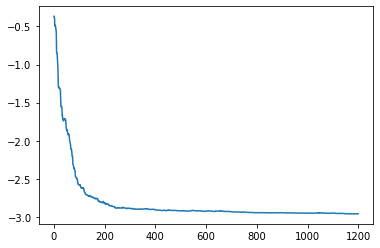

In [81]:
import matplotlib.pyplot as plt

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [84]:
import pickle

file_to_store = open("VQE_ZeroFit_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_alpha_"+str(alpha)+"_gamma_"+str(gamma)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [85]:
import pickle

file_to_read = open("VQE_ZeroFit_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_alpha_"+str(alpha)+"_gamma_"+str(gamma)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

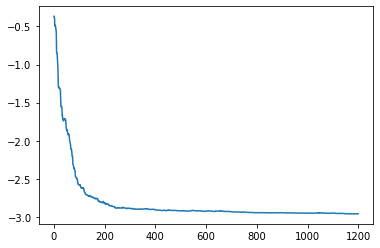

In [86]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [364]:
def SPSA_from_load(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.6
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = loaded_object[k]['Delta']
        
            
        #Find E    
        E_A = find_E(phi_k + c_k*Delta_k, blocks, method = method)
        E_B = find_E(phi_k - c_k*Delta_k, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(find_E(phi_k, blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [365]:
El,psi_f = SPSA_from_load(500,method = 'simple',hold = False)

k= 0 c_k= 0.4 a_k= 0.37053677789517936 g= 0.31221237166560845 E_A= (0.6483890629959139+0j) E_B= (0.39861916566342714+0j) E_f= -0.2941674404659663
k= 1 c_k= 0.372954594574733 a_k= 0.36411269399518237 g= -0.26600035420340845 E_A= (0.2901614058922417+0j) E_B= (0.48857351440957686+0j) E_f= -0.2754518896460993
k= 2 c_k= 0.3579898757427053 a_k= 0.35830150846605 g= -0.23292677706300263 E_A= (0.29719469765243134+0j) E_B= (0.4639655536082976+0j) E_f= -0.2587121931480509
k= 3 c_k= 0.34773782403600867 a_k= 0.3530039095073033 g= 0.21234021146877308 E_A= (0.4327031217365752+0j) E_B= (0.28502567555358105+0j) E_f= -0.2459624290385531
k= 4 c_k= 0.33998833831625347 a_k= 0.3481423907099719 g= -0.8282619743549222 E_A= (0.03284742681671075+0j) E_B= (0.5960462515196494+0j) E_f= -0.08100027444187621
k= 5 c_k= 0.3337849224236992 a_k= 0.3436553693939271 g= -0.7447356728411818 E_A= (0.2115041071735653+0j) E_B= (0.7086671847444759+0j) E_f= 0.038152202417291815
k= 6 c_k= 0.32862839767254015 a_k= 0.33949315101716

k= 52 c_k= 0.267860162826851 a_k= 0.2609058398079971 g= -0.6637781002455034 E_A= (-1.0971474553042815+0j) E_B= (-0.7415480352789647+0j) E_f= -1.0994263698402225
k= 53 c_k= 0.26735494522142605 a_k= 0.26008126905440593 g= 1.407911354082114 E_A= (-0.5476712911724904+0j) E_B= (-1.3004954170669851+0j) E_f= -1.2750908604996083
k= 54 c_k= 0.2668599250350944 a_k= 0.2592720285936403 g= 0.3115613639478683 E_A= (-1.0104499459650993+0j) E_B= (-1.176736430419019+0j) E_f= -1.2814667599546898
k= 55 c_k= 0.26637471655715955 a_k= 0.25847760404433856 g= 0.1171148371603351 E_A= (-1.027592537004671+0j) E_B= (-1.0899854001111153+0j) E_f= -1.2818743830349033
k= 56 c_k= 0.2658989552298248 a_k= 0.2576975057492954 g= 0.5293579784046106 E_A= (-0.8792011062133299+0j) E_B= (-1.1607125730140462+0j) E_f= -1.282086350580811
k= 57 c_k= 0.26543229614067565 a_k= 0.2569312672388709 g= -0.139467602267511 E_A= (-1.0908689506251905+0j) E_B= (-1.0168305388109906+0j) E_f= -1.2801628270984842
k= 58 c_k= 0.26497441264651617 a_

k= 103 c_k= 0.25023014297472496 a_k= 0.23158657254318332 g= 0.16197514333165727 E_A= (-1.5241987206105965+0j) E_B= (-1.6052608471590608+0j) E_f= -1.7613944770531855
k= 104 c_k= 0.24998840873867942 a_k= 0.23118038596666274 g= -0.10559690922187386 E_A= (-1.610454788001996+0j) E_B= (-1.5576587813937979+0j) E_f= -1.76175682998874
k= 105 c_k= 0.24974919607452548 a_k= 0.2307784194017882 g= 0.23095575564585205 E_A= (-1.5114396716308858+0j) E_B= (-1.626801700233558+0j) E_f= -1.7663220086037088
k= 106 c_k= 0.2495124552599996 a_k= 0.23038059318858709 g= 0.35943278297641235 E_A= (-1.4573368947696406+0j) E_B= (-1.636702807132399+0j) E_f= -1.7735644700799984
k= 107 c_k= 0.24927813800651724 a_k= 0.22998682983541768 g= 0.3459481684476991 E_A= (-1.506252183827228+0j) E_B= (-1.6787268143820429+0j) E_f= -1.781116290224153
k= 108 c_k= 0.24904619740500722 a_k= 0.22959705394216187 g= -0.07873932143333032 E_A= (-1.6728575169562512+0j) E_B= (-1.6336380597778082+0j) E_f= -1.7823494830513171
k= 109 c_k= 0.2488

k= 153 c_k= 0.24050294487280224 a_k= 0.21526213181371276 g= 0.008744785336365263 E_A= (-1.7012406417363366+0j) E_B= (-1.7054469349876893+0j) E_f= -1.8713081976727461
k= 154 c_k= 0.24034577371294386 a_k= 0.2149992661706627 g= 0.22835649338188035 E_A= (-1.6435933200044097+0j) E_B= (-1.7533623561728953+0j) E_f= -1.8746302585197436
k= 155 c_k= 0.2401897150315199 a_k= 0.2147383069429348 g= -0.11426817501444562 E_A= (-1.7170791951622109+0j) E_B= (-1.6621871143744278+0j) E_f= -1.8751852786255994
k= 156 c_k= 0.24003475389827156 a_k= 0.21447922894421484 g= -0.28188096762304243 E_A= (-1.780900692284657+0j) E_B= (-1.6455782349006498+0j) E_f= -1.8829435060946635
k= 157 c_k= 0.23988087567680955 a_k= 0.21422200746922634 g= -0.1585448649172057 E_A= (-1.6936271332024946+0j) E_B= (-1.617563371141693+0j) E_f= -1.884116907322624
k= 158 c_k= 0.239728066017013 a_k= 0.21396661828174487 g= -0.16711155153215504 E_A= (-1.7323649605872646+0j) E_B= (-1.6522423024714528+0j) E_f= -1.8846123935717023
k= 159 c_k= 0.

k= 203 c_k= 0.23376922896323718 a_k= 0.20405069669827428 g= 0.13578834536009146 E_A= (-1.6945963510230346+0j) E_B= (-1.7580826246170793+0j) E_f= -1.9496523984210854
k= 204 c_k= 0.23365380153244633 a_k= 0.2038595775662753 g= -0.055417386332366134 E_A= (-1.7638914421314666+0j) E_B= (-1.7379944761563675+0j) E_f= -1.950437165964479
k= 205 c_k= 0.23353899237344763 a_k= 0.20366952306447533 g= -0.11792461007270193 E_A= (-1.795947970823381+0j) E_B= (-1.74086798159856+0j) E_f= -1.9518037972365203
k= 206 c_k= 0.23342479519724088 a_k= 0.20348052237451628 g= -0.09071368922306194 E_A= (-1.6991096595159274+0j) E_B= (-1.6567600108589686+0j) E_f= -1.9520031840421188
k= 207 c_k= 0.23331120380879006 a_k= 0.20329256483718383 g= 0.0483423105819938 E_A= (-1.7528395583647574+0j) E_B= (-1.7753971637183241+0j) E_f= -1.9525761027164394
k= 208 c_k= 0.2331982121051757 a_k= 0.20310563994934921 g= -0.0935832220514162 E_A= (-1.7761447814022004+0j) E_B= (-1.7324979012713366+0j) E_f= -1.9536927717094683
k= 209 c_k= 0

k= 253 c_k= 0.22865030548461726 a_k= 0.19561802104402623 g= 0.0493258290739389 E_A= (-1.7798753465321824+0j) E_B= (-1.8024320783042587+0j) E_f= -1.9759434919769092
k= 254 c_k= 0.22855958199258958 a_k= 0.19546942243156754 g= -0.057220595838998106 E_A= (-1.798263763672948+0j) E_B= (-1.7721071327402913+0j) E_f= -1.9763447043090334
k= 255 c_k= 0.22846924936970905 a_k= 0.19532149575799884 g= 0.05709263782042086 E_A= (-1.7882460155971356+0j) E_B= (-1.814333839811872+0j) E_f= -1.9766798247858155
k= 256 c_k= 0.22837930441497245 a_k= 0.19517423547591145 g= 0.031779577093912076 E_A= (-1.801824982732855+0j) E_B= (-1.8163405781554742+0j) E_f= -1.976889071770436
k= 257 c_k= 0.22828974396591784 a_k= 0.1950276361042541 g= 0.03729601650757049 E_A= (-1.791113483104523+0j) E_B= (-1.8081420792234468+0j) E_f= -1.9768232738242546
k= 258 c_k= 0.22820056489801344 a_k= 0.19488169222729543 g= 0.006766089520059693 E_A= (-1.820123037684761+0j) E_B= (-1.8232110885860173+0j) E_f= -1.9768788105756334
k= 259 c_k= 0.

k= 303 c_k= 0.2245379531555281 a_k= 0.1889158475879403 g= -0.019615701884670322 E_A= (-1.7602038357017515+0j) E_B= (-1.7513948965999657+0j) E_f= -1.98032834121638
k= 304 c_k= 0.22446348815402628 a_k= 0.18879514811017423 g= -0.015041963527366373 E_A= (-1.807511441626499+0j) E_B= (-1.8007586984224224+0j) E_f= -1.9804480317890927
k= 305 c_k= 0.22438929147512626 a_k= 0.1886749079481776 g= -0.005379159727201483 E_A= (-1.7702282511470542+0j) E_B= (-1.7678141994672176+0j) E_f= -1.9804321975331283
k= 306 c_k= 0.2243153612798253 a_k= 0.18855512390879003 g= -0.034871426066510405 E_A= (-1.7960331364346231+0j) E_B= (-1.7803887433617192+0j) E_f= -1.9805199722103088
k= 307 c_k= 0.2242416957476633 a_k= 0.18843579283103418 g= -0.032066339120264485 E_A= (-1.7986848505079438+0j) E_B= (-1.7843036299864483+0j) E_f= -1.980643996427383
k= 308 c_k= 0.22416829307647623 a_k= 0.1883169115856913 g= 0.016437240735645058 E_A= (-1.8042523980589036+0j) E_B= (-1.811621814456097+0j) E_f= -1.9806908605402178
k= 309 c_k

k= 353 c_k= 0.22111115942370668 a_k= 0.18338756003289805 g= 0.03882221520856018 E_A= (-1.7998008757955735+0j) E_B= (-1.8169689258278963+0j) E_f= -1.9820295317492296
k= 354 c_k= 0.2210481719458794 a_k= 0.18328646055073458 g= 0.0071509458131375405 E_A= (-1.8159274534849292+0j) E_B= (-1.8190888604842854+0j) E_f= -1.982010473015273
k= 355 c_k= 0.22098537951573047 a_k= 0.18318569318138667 g= -0.0019019534642685481 E_A= (-1.8242452398534958+0j) E_B= (-1.8234046320372506+0j) E_f= -1.9820130283647297
k= 356 c_k= 0.22092278098392504 a_k= 0.18308525593090869 g= -0.0038706887352812466 E_A= (-1.8230589603195704+0j) E_B= (-1.8213487136801274+0j) E_f= -1.981995495332018
k= 357 c_k= 0.2208603752110963 a_k= 0.1829851468227179 g= -0.02755966959595011 E_A= (-1.7940244271544605+0j) E_B= (-1.7818507492191498+0j) E_f= -1.9818850452459345
k= 358 c_k= 0.22079816106773162 a_k= 0.1828853638973968 g= -0.025775513851473135 E_A= (-1.7944604951253116+0j) E_B= (-1.7830781230073494+0j) E_f= -1.98201530577851
k= 359 

k= 403 c_k= 0.2181802692919501 a_k= 0.178703962236058 g= -0.010292584394149944 E_A= (-1.8269843762250224+0j) E_B= (-1.822493098555371+0j) E_f= -1.9821872263662588
k= 404 c_k= 0.2181257984204375 a_k= 0.17861732579176134 g= -0.01397943804524545 E_A= (-1.8192733892152475+0j) E_B= (-1.813174837045071+0j) E_f= -1.9821662925072885
k= 405 c_k= 0.2180714754281335 a_k= 0.17853093970918948 g= 0.004043741360277849 E_A= (-1.7976272361660897+0j) E_B= (-1.7993908854554608+0j) E_f= -1.9821446936108817
k= 406 c_k= 0.2180172995508166 a_k= 0.17844480266562 g= 0.005504211774597279 E_A= (-1.7852497522691575+0j) E_B= (-1.7876497790436645+0j) E_f= -1.982131343482575
k= 407 c_k= 0.21796327003008015 a_k= 0.17835891334846937 g= 0.0011722443329561072 E_A= (-1.801086633472+0j) E_B= (-1.8015976458881706+0j) E_f= -1.9821261851195617
k= 408 c_k= 0.2179093861132739 a_k= 0.1782732704551914 g= 0.00961478644325766 E_A= (-1.8063669744072754+0j) E_B= (-1.8105572788301965+0j) E_f= -1.982162633667444
k= 409 c_k= 0.21785564

k= 453 c_k= 0.2156241250645643 a_k= 0.17465504553076158 g= 0.009446685368866442 E_A= (-1.8186774143847995+0j) E_B= (-1.8227512809196436+0j) E_f= -1.9826608724809287
k= 454 c_k= 0.21557621389665993 a_k= 0.17457948453338862 g= 0.0191982866251469 E_A= (-1.8247353705263607+0j) E_B= (-1.8330127584142648+0j) E_f= -1.9827637711465338
k= 455 c_k= 0.21552841852324142 a_k= 0.17450411844306418 g= -0.011228681778111526 E_A= (-1.803329787273987+0j) E_B= (-1.7984895872225128+0j) E_f= -1.9827469403049183
k= 456 c_k= 0.21548073841143345 a_k= 0.17442894634039197 g= -0.00574623040761278 E_A= (-1.7894589045678506+0j) E_B= (-1.7869825006252213+0j) E_f= -1.9827223173735788
k= 457 c_k= 0.2154331730319722 a_k= 0.1743539673122692 g= -0.007685584631084743 E_A= (-1.8168967167008234+0j) E_B= (-1.8135852569334627+0j) E_f= -1.9826985403407287
k= 458 c_k= 0.21538572185917312 a_k= 0.1742791804518308 g= 0.0124803870127395 E_A= (-1.802406528289735+0j) E_B= (-1.8077827226213765+0j) E_f= -1.982694716952244
k= 459 c_k= 0

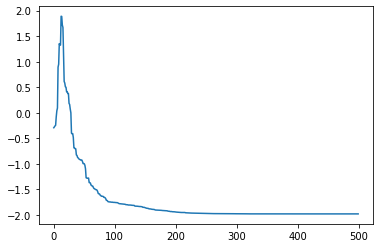

In [367]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [30]:
pwd

'C:\\Users\\jsten\\IBMQ\\Hubbard_symmetries'